# House Hold Energy Data - Time Series

## Data Loading and Exploration

In [ ]:
import kaggle
import os

# Define the path
path = "../datasets/vitthalmadane/energy-consumption-time-series-dataset"

# Check if the directory exists
if not os.path.exists(path):
    # Create the directory
    os.makedirs(path)
    print(f"Directory created at: {path}")
else:
    print(f"Directory already exists at: {path}")

## Make sure that kaggle.json is in C:\Users\<username>\.kaggle
# kaggle.api.authenticate()

path = "../datasets/vitthalmadane/energy-consumption-time-series-dataset"

# kaggle.api.dataset_download_files('vitthalmadane/energy-consumption-time-series-dataset', path=path, unzip=True)

In [ ]:
import pandas as pd

# Set the directory containing the files
files = os.listdir(path)

# Initialize an empty list to store dataframes
dataframes = []

# Loop through the files in the directory
for file in files:
    # Create the full file path
    file_path = os.path.join(path, file)
    
    # Read the CSV file
    data = pd.read_csv(file_path)
    
    # Combine the 'TxnDate' and 'TxnTime' columns into a single datetime column
    data['datetime'] = pd.to_datetime(data['TxnDate'] + ' ' + data['TxnTime'])
    
    # Drop unnecessary columns
    data = data.drop(["Unnamed: 0", "TxnTime", "TxnDate"], axis=1)
    
    # Sort by datetime and set it as the index
    data = data.sort_values(by="datetime").set_index("datetime")
    
    # Append the processed dataframe to the list
    dataframes.append(data)

# Concatenate all the dataframes into a single dataframe
data = pd.concat(dataframes)

# Optionally, reset the index if needed
# merged_data = merged_data.reset_index()

# Display the first few rows of the merged data
print(data.head())


                     Consumption
datetime                        
2022-01-01 00:22:28        1.030
2022-01-01 00:42:33        0.904
2022-01-01 01:01:51        0.904
2022-01-01 01:41:48        1.850
2022-01-01 02:22:52        1.878


In [158]:
## check for null values

pd.isnull(data).sum()

Consumption    0
dtype: int64

In [159]:
data.describe()

,Consumption
count,3606.000000
mean,2.781508
std,2.961248
min,0.000000
25%,0.948000
50%,1.032000
75%,4.005500
max,27.284000


In [160]:
data["Consumption"].min()

0.0

In [161]:
data["Consumption"].max()

27.284

<strong>No null values</strong>

In [162]:
import numpy as np
## Add 1 to all data

# data['Consumption'] = data['Consumption'] + 1  # Ensure all values are >= 1
# Handle zero and negative values
data[data <= 0] = 1e-6

# Apply log transformation
log_data = np.log(data)

print("Transformed Data:")
print(log_data)

data['log_Consumption'] = np.log(data['Consumption'])

Transformed Data:
                     Consumption
datetime                        
2022-01-01 00:22:28     0.029559
2022-01-01 00:42:33    -0.100926
2022-01-01 01:01:51    -0.100926
2022-01-01 01:41:48     0.615186
2022-01-01 02:22:52     0.630207
...                          ...
2022-02-28 22:25:43     0.141500
2022-02-28 22:44:37    -0.118784
2022-02-28 23:07:15     0.062035
2022-02-28 23:29:13     0.035367
2022-02-28 23:50:27     0.000000

[3606 rows x 1 columns]


In [163]:
import matplotlib.pyplot as plt

def plot_hist(data):
  # Plot the histogram
  plt.figure(figsize=(8, 6))
  plt.hist(data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

  # Add titles and labels
  plt.title('Distribution of Consumption', fontsize=16)
  plt.xlabel('Consumption', fontsize=14)
  plt.ylabel('Frequency', fontsize=14)

  # Show grid for better readability
  plt.grid(axis='y', linestyle='--', alpha=0.7)

  # Display the plot
  plt.tight_layout()
  plt.show()

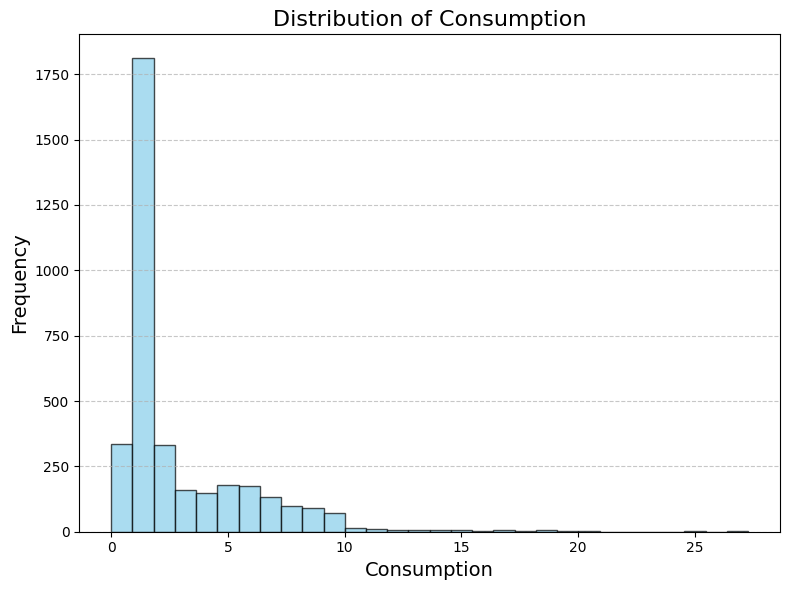

In [164]:
plot_hist(data['Consumption'])

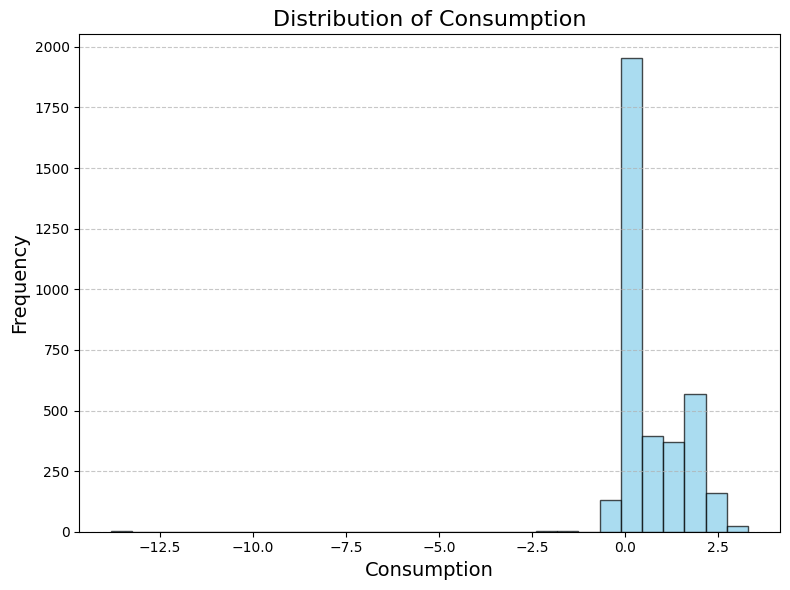

In [165]:

# Apply log transformation to the 'Consumption' column
data['log_Consumption'] = np.log(data['Consumption'])

# Plot or check the distribution before and after
plot_hist(data['log_Consumption'])

<strong>right skew data</strong>

In [166]:
import plotly.graph_objects as go

def plot_data_interactive(x, y):
    # Create an interactive time series plot
    fig = go.Figure()

    # Add a line trace for Consumption
    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='lines+markers',
        line=dict(color='blue'),
        marker=dict(size=5),
        name='Consumption'
    ))

    # Add titles and labels
    fig.update_layout(
        title='Interactive Time Series of Consumption',
        xaxis_title='Datetime',
        yaxis_title='Consumption',
        template='plotly_white',
        xaxis=dict(rangeslider=dict(visible=True)),  # Enable zoom slider
        yaxis=dict(fixedrange=False)  # Allow zoom on the y-axis
    )

    # Show the plot
    fig.show()


In [167]:
## plot pre-interpolated data

plot_data_interactive(data.index, data['log_Consumption'])

In [168]:
## function for interpolation
## default to linear interpolation
def interpolate(data, resolution, interploation = "linear"):
  return data.resample(resolution).mean().interpolate(interploation)

## sample interpolation for getting mean of every 15 minutes
int_data = interpolate(data, "1h")

int_data.head()

,Consumption,log_Consumption
datetime,,
2022-01-01 00:00:00,0.967000,-0.035684
2022-01-01 01:00:00,1.377000,0.257130
2022-01-01 02:00:00,1.485000,0.359109
2022-01-01 03:00:00,0.929333,-0.073351
2022-01-01 04:00:00,0.922667,-0.080723


In [169]:
## plot interpolated data

plot_data_interactive(data.index, data['log_Consumption'])

<strong>To reverse log transformaton</strong> which is important for interpreting machine learning predicitons


<i>np.exp(data['log_Consumption'])</i>

## Model Creation

Epoch 1/64
33/33 [==============================] - 2s 21ms/step - loss: 0.9027 - val_loss: 0.5491
Epoch 2/64
33/33 [==============================] - 0s 8ms/step - loss: 0.7096 - val_loss: 0.5163
Epoch 3/64
33/33 [==============================] - 0s 8ms/step - loss: 0.6593 - val_loss: 0.4897
Epoch 4/64
33/33 [==============================] - 0s 8ms/step - loss: 0.5954 - val_loss: 0.4579
Epoch 5/64
33/33 [==============================] - 0s 8ms/step - loss: 0.5606 - val_loss: 0.4339
Epoch 6/64
33/33 [==============================] - 0s 8ms/step - loss: 0.5295 - val_loss: 0.4093
Epoch 7/64
33/33 [==============================] - 0s 8ms/step - loss: 0.4871 - val_loss: 0.3714
Epoch 8/64
33/33 [==============================] - 0s 8ms/step - loss: 0.4471 - val_loss: 0.3536
Epoch 9/64
33/33 [==============================] - 0s 8ms/step - loss: 0.4554 - val_loss: 0.3270
Epoch 10/64
33/33 [==============================] - 0s 8ms/step - loss: 0.4477 - val_loss: 0.3148
Epoch 11/64
33/33 

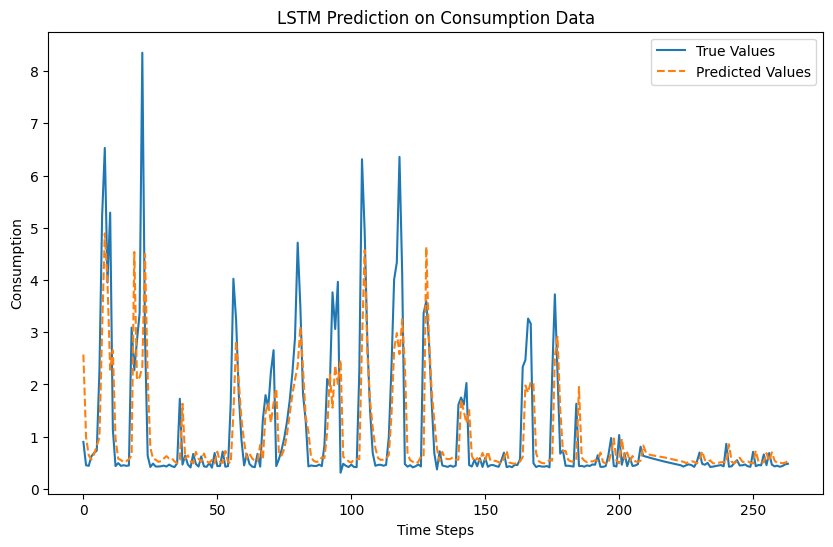

In [195]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Normalize data
scaler = StandardScaler()
int_data['log_Consumption'] = scaler.fit_transform(int_data[['log_Consumption']])

# Prepare sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 1*4*24  # Number of past timesteps to consider
data = int_data['log_Consumption'].values
X, y = create_sequences(data, sequence_length)

# Reshape X for LSTM (samples, timesteps, features)
X = X.reshape((X.shape[0], sequence_length, 1))

# Train/Test Split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM Model
model = Sequential([
    # LSTM(64, activation='tanh', input_shape=(sequence_length, 1), return_sequences=True),
    # Dropout(0.5),
    LSTM(32, activation='tanh', input_shape=(sequence_length, 1)),
    Dropout(0.5),
    Dense(1)  # Predict a single value
])
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=64, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Make Predictions
y_pred = model.predict(X_test)

# Reverse scaling to get original values
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler.inverse_transform(y_pred)

y_test_original = np.exp(y_test_original)
y_pred_original = np.exp(y_pred_original)

# Visualize Predictions
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_original)), y_test_original, label="True Values")
plt.plot(range(len(y_pred_original)), y_pred_original, label="Predicted Values", linestyle='--')
plt.title("LSTM Prediction on Consumption Data")
plt.xlabel("Time Steps")
plt.ylabel("Consumption")
plt.legend()
plt.show()
